# 基于经典网络架构训练图像分类模型

### 数据预处理部分：

- 数据增强：torchvision中transforms模块自带功能，比较实用
- 数据预处理：torchvision中transforms也帮我们实现好了，直接调用即可
- DataLoader模块直接读取batch数据

### 网络模块设置：

- 加载预训练模型，torchvision中有很多经典网络架构，调用起来十分方便，并且可以用人家训练好的权重参数来继续训练，也就是所谓的迁移学习
- 需要注意的是别人训练好的任务跟咱们的可不是完全一样，需要把最后的head层改一改，一般也就是最后的全连接层，改成咱们自己的任务
- 训练时可以全部重头训练，也可以只训练最后咱们任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试

![title](1.png)

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import copy
import json
from PIL import Image

### 数据读取与预处理操作

In [2]:
data_dir = './flower_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

### 制作好数据源：
- data_transforms中指定了所有图像预处理操作
- ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字

# 数据增强
数据量太少，可以使用数据增强高效利用测试数据
旋转
侧翻
......
![image.png](./imgs/1.png)

In [3]:
data_transforms = {
    'train':
        # 组合，按顺序依次完成以下任务
        transforms.Compose([
        # 统一花的尺寸
        transforms.Resize([96, 96]),
        # 随机旋转，-45到45度之间随机选
        transforms.RandomRotation(45),
        # 从中心开始裁剪
        transforms.CenterCrop(64),
        # 随机水平翻转 选择一个概率概率
        transforms.RandomHorizontalFlip(p=0.5),
        # 随机垂直翻转
        transforms.RandomVerticalFlip(p=0.5),
        # 参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
        # 概率转换成灰度率，3通道就是R=G=B
        transforms.RandomGrayscale(p=0.025),
        # 必做
        transforms.ToTensor(),
        # 均值，标准差
        # 利用经过检验的标准差、均值来做任务（一些现有的，好的，成熟的试验结论数据）
        # 三个参数分别代表 R、G、B
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': 
        transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        # 测试数据 和 验证数据 的均值和标准差需要一致
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
batch_size = 128
# 读取文件夹内的训练、测试数据集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# 计算下训练集和验证集的数据总数
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [5]:
print(len(image_datasets['train']))
print(len(image_datasets['valid']))

6552
818


In [6]:
# 总数 / batch_size-128
print(len(dataloaders['train']))
print(len(dataloaders['valid']))

52
7


### 读取标签对应的实际名字

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
cat_to_name_dict = dict(sorted(cat_to_name.items(), key=lambda item: item[0]))  
print('类别个数: ', len(cat_to_name_dict.keys()))

类别个数:  102


### 加载models中提供的模型，并且直接用训练的好权重当做初始化参数
- 第一次执行需要下载，可能会比较慢，我会提供给大家一份下载好的，可以直接放到相应路径

In [9]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
# 判断当前使用 CPU 还是 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available.  Training on CPU ...


#### 模型参数要不要更新
- 有时候用人家模型，就一直用了，更不更新咱们可以自己定

In [10]:
# 模型权重参数等部分的训练过程暂时不用 “冻结” 起来，仅用 输出层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
# 18层的能快点，条件好点的也可以选152
model_ft = models.resnet152()
my_models = model_ft._modules
for key, _ in my_models.items():
    print(key)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


### 把模型输出层改成自己的

In [12]:
# 由于初始模型的配置不太符合本案例
# 比如 resnet18 初始是 1000 分类任务，所以需要修改下
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 定义网络结构
    model_ft = model_name(pretrained=use_pretrained)
    # 禁止更新模型中的权重参数（因为本次案例训练数据过少，更新参数效果不一定好，所以直接用前人训练好的模型参数）
    set_parameter_requires_grad(model_ft, feature_extract)
    # 根据网络结构重新定义适配本案例的全连接层
    num_ftrs = model_ft.fc.in_features
    # 类别数自己根据自己任务来
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    # 输入大小根据自己配置来
    input_size = 64

    return model_ft, input_size

# 定义模型名字和参数

In [13]:
# 可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']，常见的是 resnet
model_fun = {  
    "resnet18": models.resnet18,
    "resnet50": models.resnet50,
    "resnet101": models.resnet101,
    "resnet152": models.resnet152
}
# 是否用人家训练好的特征来做
# 都用人家特征，咱先不更新
# 如果为 True ，除了输出层以外的训练层全部冻住，只训练输出层
feature_extract = True
# 分类个数
num_classes = 102
# 模型保存，名字自己起
# 将训练完之后最好的模型保存下来-网络结构图、权重参数等
filename='best.pt'

### 设置哪些层需要训练

In [14]:
model_ft, input_size = initialize_model(model_fun['resnet18'], num_classes, feature_extract, use_pretrained=True)

# GPU还是CPU计算
model_ft = model_ft.to(device)

# 是否训练所有层
params_to_update = model_ft.parameters()
if feature_extract:
    names_to_update = []
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            names_to_update.append(name)
            params_to_update.append(param)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            continue

In [15]:
# 原模型需要训练更新的网络层
for item_key, item_value in model_ft.named_parameters():
    # print(item_key)
    continue
print('----------------------------------------------')
# 过滤后本次案例需要用到的模型
for item_key in names_to_update:
    # print(item_key)
    continue

----------------------------------------------


### 优化器设置

In [16]:
# 优化器设置
#  要训练啥参数，你来定
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
#  学习率 每7个epoch 衰减成原来的 1/10
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
#  损失函数
criterion = nn.CrossEntropyLoss()

### 训练模块

In [17]:
# 开始训练
# model-模型
# dataloaders-训练数据、测试数据
# criterion-损失函数
# optimizer-优化器
# num_epochs-迭代次数
# filename-训练最好的模型的文件名
def train_model(model, dataloaders, criterion, optimizer, num_epochs, filename):
    # ************************************初始化参数-开始************************************
    # 开始训练时间
    since = time.time()
    # 也要记录最好的那一次
    best_acc = 0
    # 模型也得放到你的CPU或者GPU
    model.to(device)
    # 训练过程中打印一堆损失和指标
    # 训练集准确率
    val_acc_history = []
    # 验证集准确率
    train_acc_history = []
    # 训练集损失率
    train_losses = []
    # 验证集损失率
    valid_losses = []
    # 学习率-pytorch规定的
    LRs = [optimizer.param_groups[0]['lr']]
    # 最好的那次模型，后续会变的，先初始化
    best_model_wts = copy.deepcopy(model.state_dict())
    # ************************************初始化参数-结束************************************
    # 一个一个 epoch 来遍历
    for epoch in range(num_epochs):
        print('-' * 50)
        print('第', epoch + 1, '次 epoch 遍历')
        # 本次迭代开始时间
        curr_since = time.time()

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                # 训练
                model.train()
            else:
                # 验证
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # 取数据和标签
            for inputs, labels in dataloaders[phase]:
                # 放到 CPU 或 GPU
                # 数据
                inputs = inputs.to(device)
                # 标签
                labels = labels.to(device)
                # 梯度清零
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                # 只有训练的时候计算和更新梯度
                # 训练阶段更新权重
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 计算损失
                # 0表示 batch 那个维度
                running_loss += loss.item() * inputs.size(0)
                # 预测正确的个数
                # 预测结果最大的和真实值是否一致
                running_corrects += torch.sum(preds == labels.data)
                
            
            # 平均损失
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # 平均准确率
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # 一个epoch我浪费了多少时间
            time_elapsed = time.time() - curr_since
            print('本次迭代耗时 {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} 损失率: {:.4f} 准确率: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  # 字典里 key 就是各层的名字，值就是训练好的权重
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('学习率: {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        # 学习率衰减
        scheduler.step()

    time_elapsed = time.time() - since
    print('训练耗时: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('最高准确率的 epoch: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

### 开始训练！

- 我们现在只训练了输出层

In [18]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model=model_ft, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer_ft, num_epochs=25, filename=filename)

--------------------------------------------------
第 1 次 epoch 遍历
本次迭代耗时 0m 32s
train 损失率: 3.9715 准确率: 0.2421
本次迭代耗时 0m 36s
valid 损失率: 3.4573 准确率: 0.2628
学习率: 0.0100000
--------------------------------------------------
第 2 次 epoch 遍历
本次迭代耗时 0m 37s
train 损失率: 2.8036 准确率: 0.4017
本次迭代耗时 0m 40s
valid 损失率: 3.3631 准确率: 0.3154
学习率: 0.0100000
--------------------------------------------------
第 3 次 epoch 遍历
本次迭代耗时 0m 36s
train 损失率: 2.7381 准确率: 0.4203
本次迭代耗时 0m 40s
valid 损失率: 3.8122 准确率: 0.3191
学习率: 0.0100000
--------------------------------------------------
第 4 次 epoch 遍历
本次迭代耗时 0m 36s
train 损失率: 2.7631 准确率: 0.4335
本次迭代耗时 0m 40s
valid 损失率: 3.6548 准确率: 0.3362
学习率: 0.0100000
--------------------------------------------------
第 5 次 epoch 遍历
本次迭代耗时 0m 37s
train 损失率: 2.7538 准确率: 0.4388
本次迭代耗时 0m 40s
valid 损失率: 3.8362 准确率: 0.3289
学习率: 0.0100000
--------------------------------------------------
第 6 次 epoch 遍历
本次迭代耗时 0m 37s
train 损失率: 2.8578 准确率: 0.4368
本次迭代耗时 0m 41s
valid 损失率: 3.8606 准确率: 0.3447
学

# 二、再继续训练所有层

In [19]:
# 打开冻结的部分训练层，使用整个网络的全部层进行训练
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
# 学习率衰减
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.CrossEntropyLoss()

In [20]:
# 加载之前训练好的权重参数
# 将训练效果最好的一次权重参数等加载进来
filename='best.pt'
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=25, filename=filename)

--------------------------------------------------
第 1 次 epoch 遍历
本次迭代耗时 1m 7s
train 损失率: 2.7436 准确率: 0.4177
本次迭代耗时 1m 11s
valid 损失率: 2.6074 准确率: 0.4144
学习率: 0.0010000
--------------------------------------------------
第 2 次 epoch 遍历
本次迭代耗时 1m 8s
train 损失率: 1.5497 准确率: 0.5971
本次迭代耗时 1m 11s
valid 损失率: 1.9051 准确率: 0.5318
学习率: 0.0010000
--------------------------------------------------
第 3 次 epoch 遍历
本次迭代耗时 1m 8s
train 损失率: 1.1201 准确率: 0.6955
本次迭代耗时 1m 12s
valid 损失率: 1.5305 准确率: 0.6088
学习率: 0.0010000
--------------------------------------------------
第 4 次 epoch 遍历
本次迭代耗时 1m 8s
train 损失率: 0.9231 准确率: 0.7392
本次迭代耗时 1m 12s
valid 损失率: 1.7075 准确率: 0.5758
学习率: 0.0010000
--------------------------------------------------
第 5 次 epoch 遍历
本次迭代耗时 1m 8s
train 损失率: 0.8290 准确率: 0.7639
本次迭代耗时 1m 11s
valid 损失率: 1.6866 准确率: 0.6015
学习率: 0.0010000
--------------------------------------------------
第 6 次 epoch 遍历
本次迭代耗时 1m 8s
train 损失率: 0.9136 准确率: 0.7476
本次迭代耗时 1m 12s
valid 损失率: 2.0474 准确率: 0.5306
学习率: 0.

KeyboardInterrupt: 

### 加载训练好的模型

In [22]:
# 如果发生电脑关机等事故，可以使用这种方法加载训练好的模型，无需再次重新训练
model_ft, input_size = initialize_model(model_name=model_fun['resnet18'], num_classes=102, feature_extract=feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### 测试数据预处理

- 测试数据处理方法需要跟训练时一直才可以 
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换


In [23]:
# 得到一个 batch 的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()

# 验证模式
model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

output表示对一个batch中每一个数据得到其属于各个类别的可能性

In [24]:
# out1-batch
# out2-类别概率
output.shape

torch.Size([128, 102])

### 得到概率最大的那个

In [25]:
# 得到可能性最大的类别预测ID
_, preds_tensor = torch.max(output, 1)
# 得到当前 batch 中 128 个样本的预测结果
# gpu -> cpu 即 tensor -> numpy
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

### 展示预测结果

In [26]:
def im_convert(tensor):
    """ 展示数据"""
    # 从 tensor cpu 中取出图像数据
    image = tensor.to("cpu").clone().detach()
    # 将 tensor 转为 numpy 格式
    image = image.numpy().squeeze()
    # arg1-长
    # arg2-宽
    # arg3-通道数-RGB、灰度图
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    # 防止数值越界或异常等
    image = image.clip(0, 1)

    return image

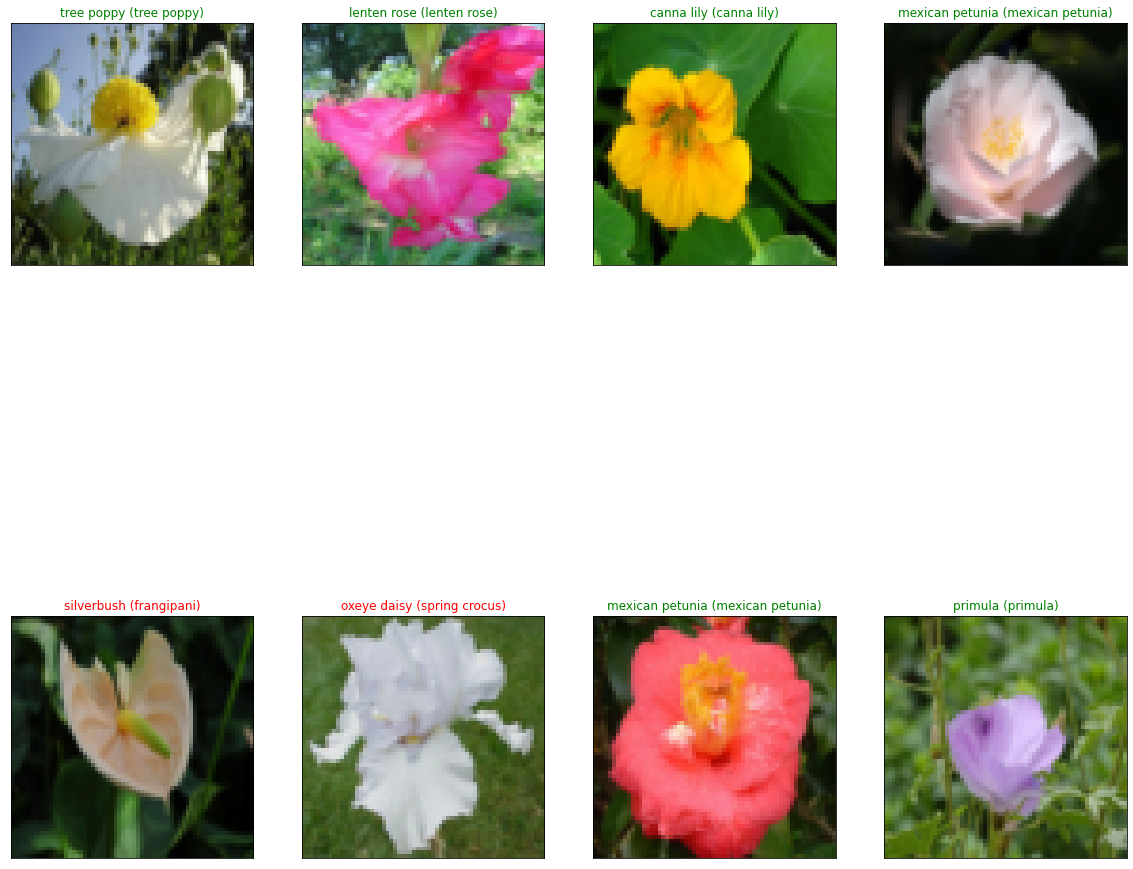

In [27]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

# 绿色代表预测正确
# 红色代表越策错误
for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(
        "{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
        color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red")
    )
plt.show()